# Data Analysis-- Supervised Learning
* Created on Feb 6, 2023 by Shangying Wang
* Last Modified: Feb 13, 2023 by  Jie Shi
* this code is used for prediction of the mean fold change from the overexpression of genes and/or knockout of genes
* this code also screen possibel combinations of overexpressed genes
* this code used gradient boosting regressor

In [1]:
%load_ext autoreload
%autoreload 2
from mylib import *

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import csv
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.keras.optimizers import SGD, Adam
from keras import layers,Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Average, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.layers import Conv1D,MaxPool1D, concatenate
from keras.initializers import RandomNormal,HeNormal,GlorotNormal,HeUniform,LecunNormal,LecunUniform,Orthogonal
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from itertools import product
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

In [4]:
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['xtick.labelsize'] = 18
#plt.rcParams['xtick.major.size'] = 3
#plt.rcParams['xtick.major.width'] = 2
#plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.labelsize'] = 20
#plt.rcParams['ytick.major.width'] = 1
#plt.rcParams['ytick.minor.size'] = 5
#plt.rcParams['figure.figsize'] =  (30, 30)
plt.rcParams['axes.titlesize'] = 18

plt.rcParams['axes.labelsize'] = 20
#plt.rcParams['axes.labelsize'] = 16

plt.rcParams['axes.grid'] = False
# Resolution
# Legend Parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['legend.fontsize'] = 16

# For peroxisome data analysis

1. There are 25 overexpressed genes;
2. There are 23 genes that have a delta sign in front of the gene name. This means that those genes were knocked out or removed from the genome;
3. The last column is the main output - it shows the fold change for that case compared to WT;

## Load data from file

In [5]:
all_data=pd.read_csv('data/all_data_duplicated_removed_139samples_before_cleaning_first_round.csv',sep=',')
#all_data=pd.read_csv('../data/all_data_duplicated_removed.csv',sep=',')
#all_data.drop(['Case #', 'OE/KO test case average (Relative fluorescence units/ Optical density)', 'OE/KO test case standard deviation', 'WT average (Relative fluorescence units/ Optical density)', 'WT standard deviation'], axis=1, inplace=True)
all_data.drop(['Unnamed: 0','capacity_std','capacity_instances'], axis=1, inplace=True)
all_data

,Pex1,Pex2,Pex3,Pex4,Pex5,Pex6,Pex8,Pex10,Pex11,Pex12,...,ΔAtg15,ΔVps1,ΔTgl1,ΔTgl5,ΔPex29,ΔMmm1,ΔMdm10,ΔMdm12,ΔInp2,capacity_mean
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.5700
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.2850
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.9400
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.2400
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.1733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,2.5400
135,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1.6500
136,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,2.4800
137,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1.8600


In [6]:
all_data.columns

Index(['Pex1', 'Pex2', 'Pex3', 'Pex4', 'Pex5', 'Pex6', 'Pex8', 'Pex10',
       'Pex11', 'Pex12', 'Pex13', 'Pex14', 'Pex15', 'Pex17', 'Pex19', 'Pex22',
       'Pex25', 'Pex27', 'Pex28', 'Pex29', 'Pex30', 'Pex31', 'Pex32', 'Pex34',
       'Sei1', 'Rtn1', 'Vps1', 'Ant1', 'Arf3', 'Cbf1', 'Mig3', 'ΔPex9',
       'ΔPex11', 'ΔPex31', 'ΔPex32', 'ΔPex27', 'ΔAtg11', 'ΔAtg36', 'ΔDoa1',
       'ΔCmp2', 'ΔMsn4', 'ΔTec1', 'ΔHac1', 'ΔRpn4', 'ΔAtg1', 'ΔAtg15', 'ΔVps1',
       'ΔTgl1', 'ΔTgl5', 'ΔPex29', 'ΔMmm1', 'ΔMdm10', 'ΔMdm12', 'ΔInp2',
       'capacity_mean'],
      dtype='object')

In [7]:
# We removed the genes that only show up once, by itself, without any interactions with other genes from the combinatorial screening, i.e., Mig3, Cbf1;
# We also delete Ant1 and Arf3, there is only one data point for the combination of the two genes. Their interactions with other genes are unclear.
# Pex25 genes has 2 data points, both only have pex25 genes. We removed these 2 data points from current analysis.
# Pex27 genes has 2 data points, both only have pex27 genes,We removed these 2 data points from current analysis.
columns_remove = ['Mig3','Cbf1','Ant1','Arf3','Pex25','Pex27', 'ΔPex9',
                  'ΔPex31','ΔPex32','ΔPex27', 'ΔAtg36','ΔCmp2', 'ΔMsn4','ΔTec1','ΔHac1','ΔRpn4','ΔAtg1','ΔAtg15','ΔVps1','ΔTgl5','ΔMmm1','ΔMdm10','ΔInp2']


In [8]:
# Remove rows where any value in each column from your list is not zero
all_data = all_data[(all_data[columns_remove] == 0).all(axis=1)]
# Remove the columns from the list
all_data = all_data.drop(columns=columns_remove)

In [9]:
display(all_data)

,Pex1,Pex2,Pex3,Pex4,Pex5,Pex6,Pex8,Pex10,Pex11,Pex12,...,Sei1,Rtn1,Vps1,ΔPex11,ΔAtg11,ΔDoa1,ΔTgl1,ΔPex29,ΔMdm12,capacity_mean
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.2850
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.1733
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.3400
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.5967
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.7946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,2.5400
135,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,1.6500
136,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,1,0,0,0,0,2.4800
137,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,1.8600


In [10]:
data_head = list(all_data.columns) 
data_head

['Pex1',
 'Pex2',
 'Pex3',
 'Pex4',
 'Pex5',
 'Pex6',
 'Pex8',
 'Pex10',
 'Pex11',
 'Pex12',
 'Pex13',
 'Pex14',
 'Pex15',
 'Pex17',
 'Pex19',
 'Pex22',
 'Pex28',
 'Pex29',
 'Pex30',
 'Pex31',
 'Pex32',
 'Pex34',
 'Sei1',
 'Rtn1',
 'Vps1',
 'ΔPex11',
 'ΔAtg11',
 'ΔDoa1',
 'ΔTgl1',
 'ΔPex29',
 'ΔMdm12',
 'capacity_mean']

In [11]:
#data statistics
stats_df = all_data.describe()
stats_df

,Pex1,Pex2,Pex3,Pex4,Pex5,Pex6,Pex8,Pex10,Pex11,Pex12,...,Sei1,Rtn1,Vps1,ΔPex11,ΔAtg11,ΔDoa1,ΔTgl1,ΔPex29,ΔMdm12,capacity_mean
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,...,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,0.358974,0.299145,0.393162,0.358974,0.615385,0.094017,0.196581,0.299145,0.264957,0.333333,...,0.230769,0.230769,0.008547,0.059829,0.230769,0.034188,0.017094,0.034188,0.017094,1.364730
std,0.481763,0.459853,0.490553,0.481763,0.488597,0.293108,0.399122,0.459853,0.443209,0.473432,...,0.423137,0.423137,0.092450,0.238190,0.423137,0.182493,0.130179,0.182493,0.130179,0.490939
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.175000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.040000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.285000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.680000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.760000


In [12]:
skew_vals=all_data['capacity_mean'].skew()
skew_vals

0.6498831959942142

<AxesSubplot:>

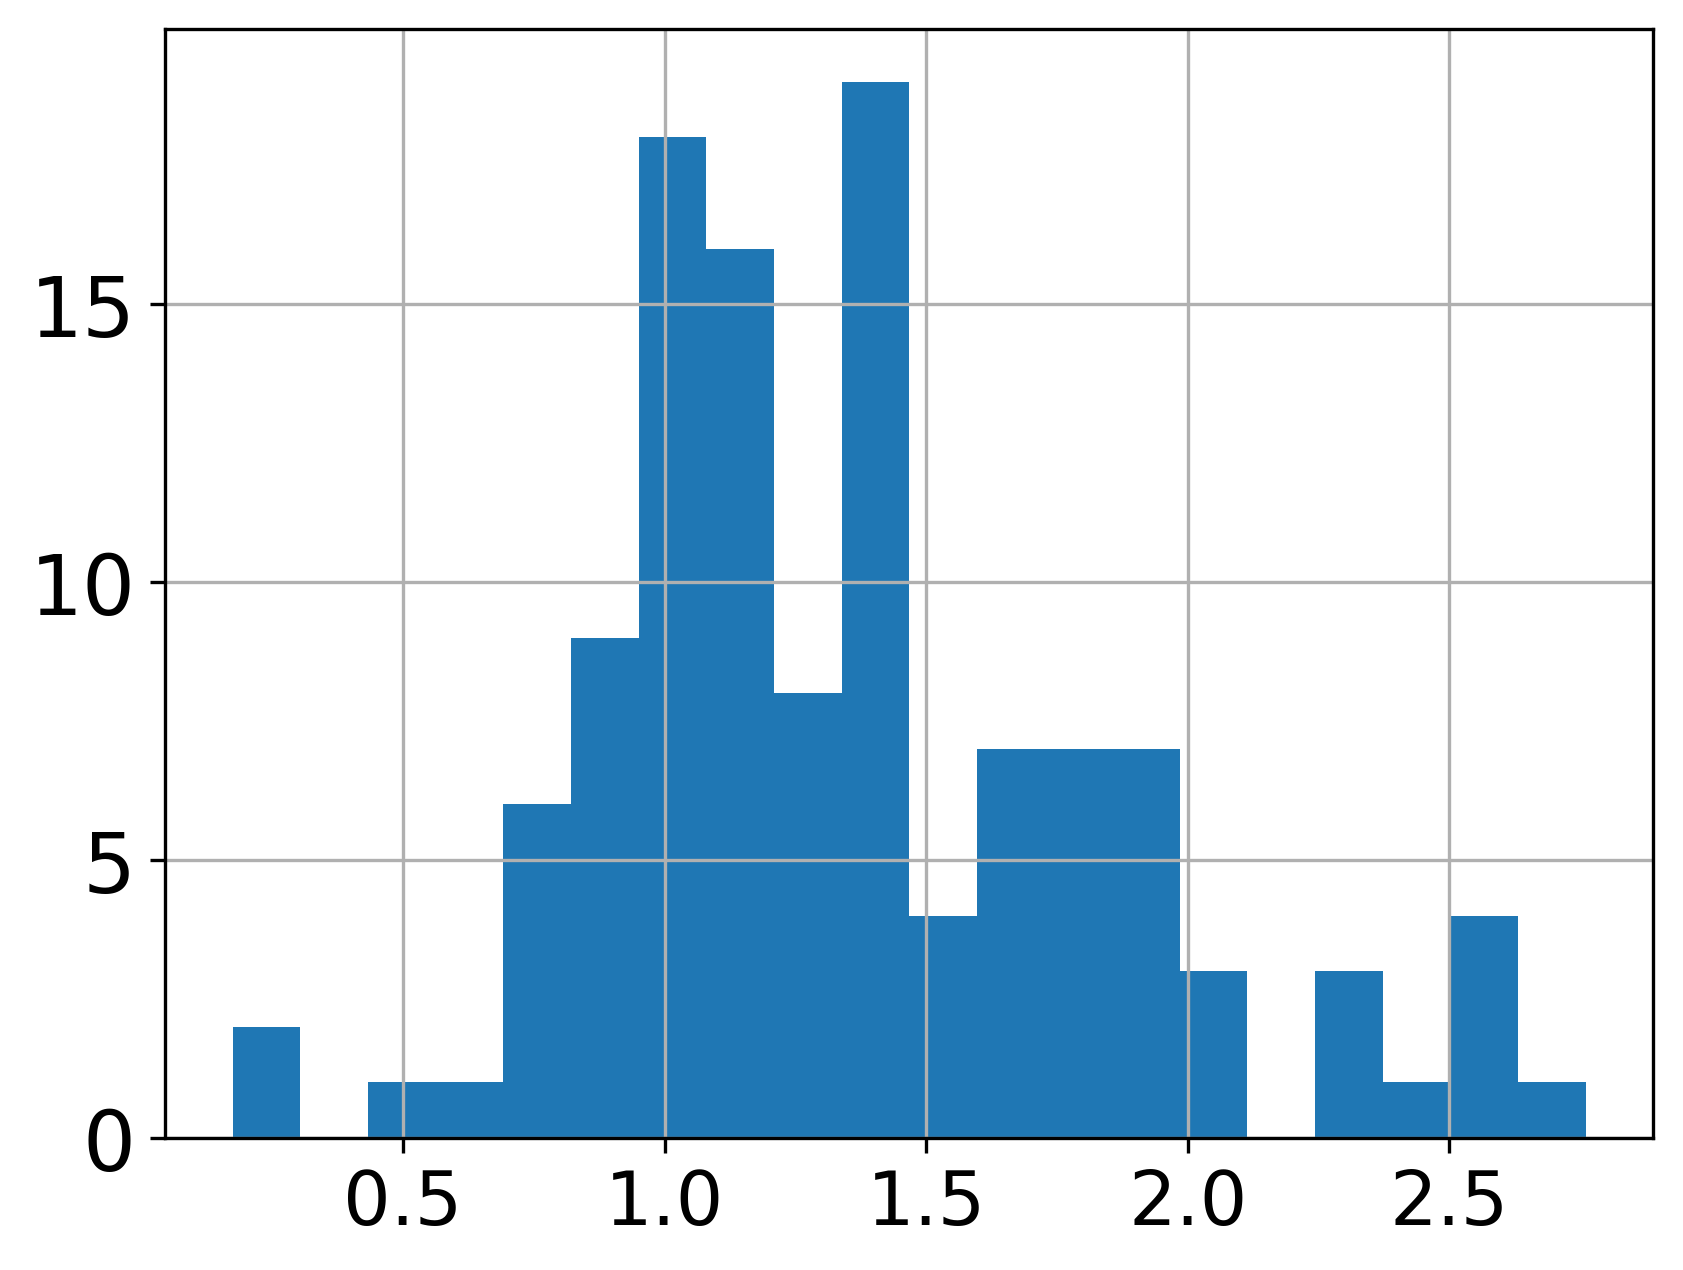

In [13]:
all_data['capacity_mean'].hist(bins=20)

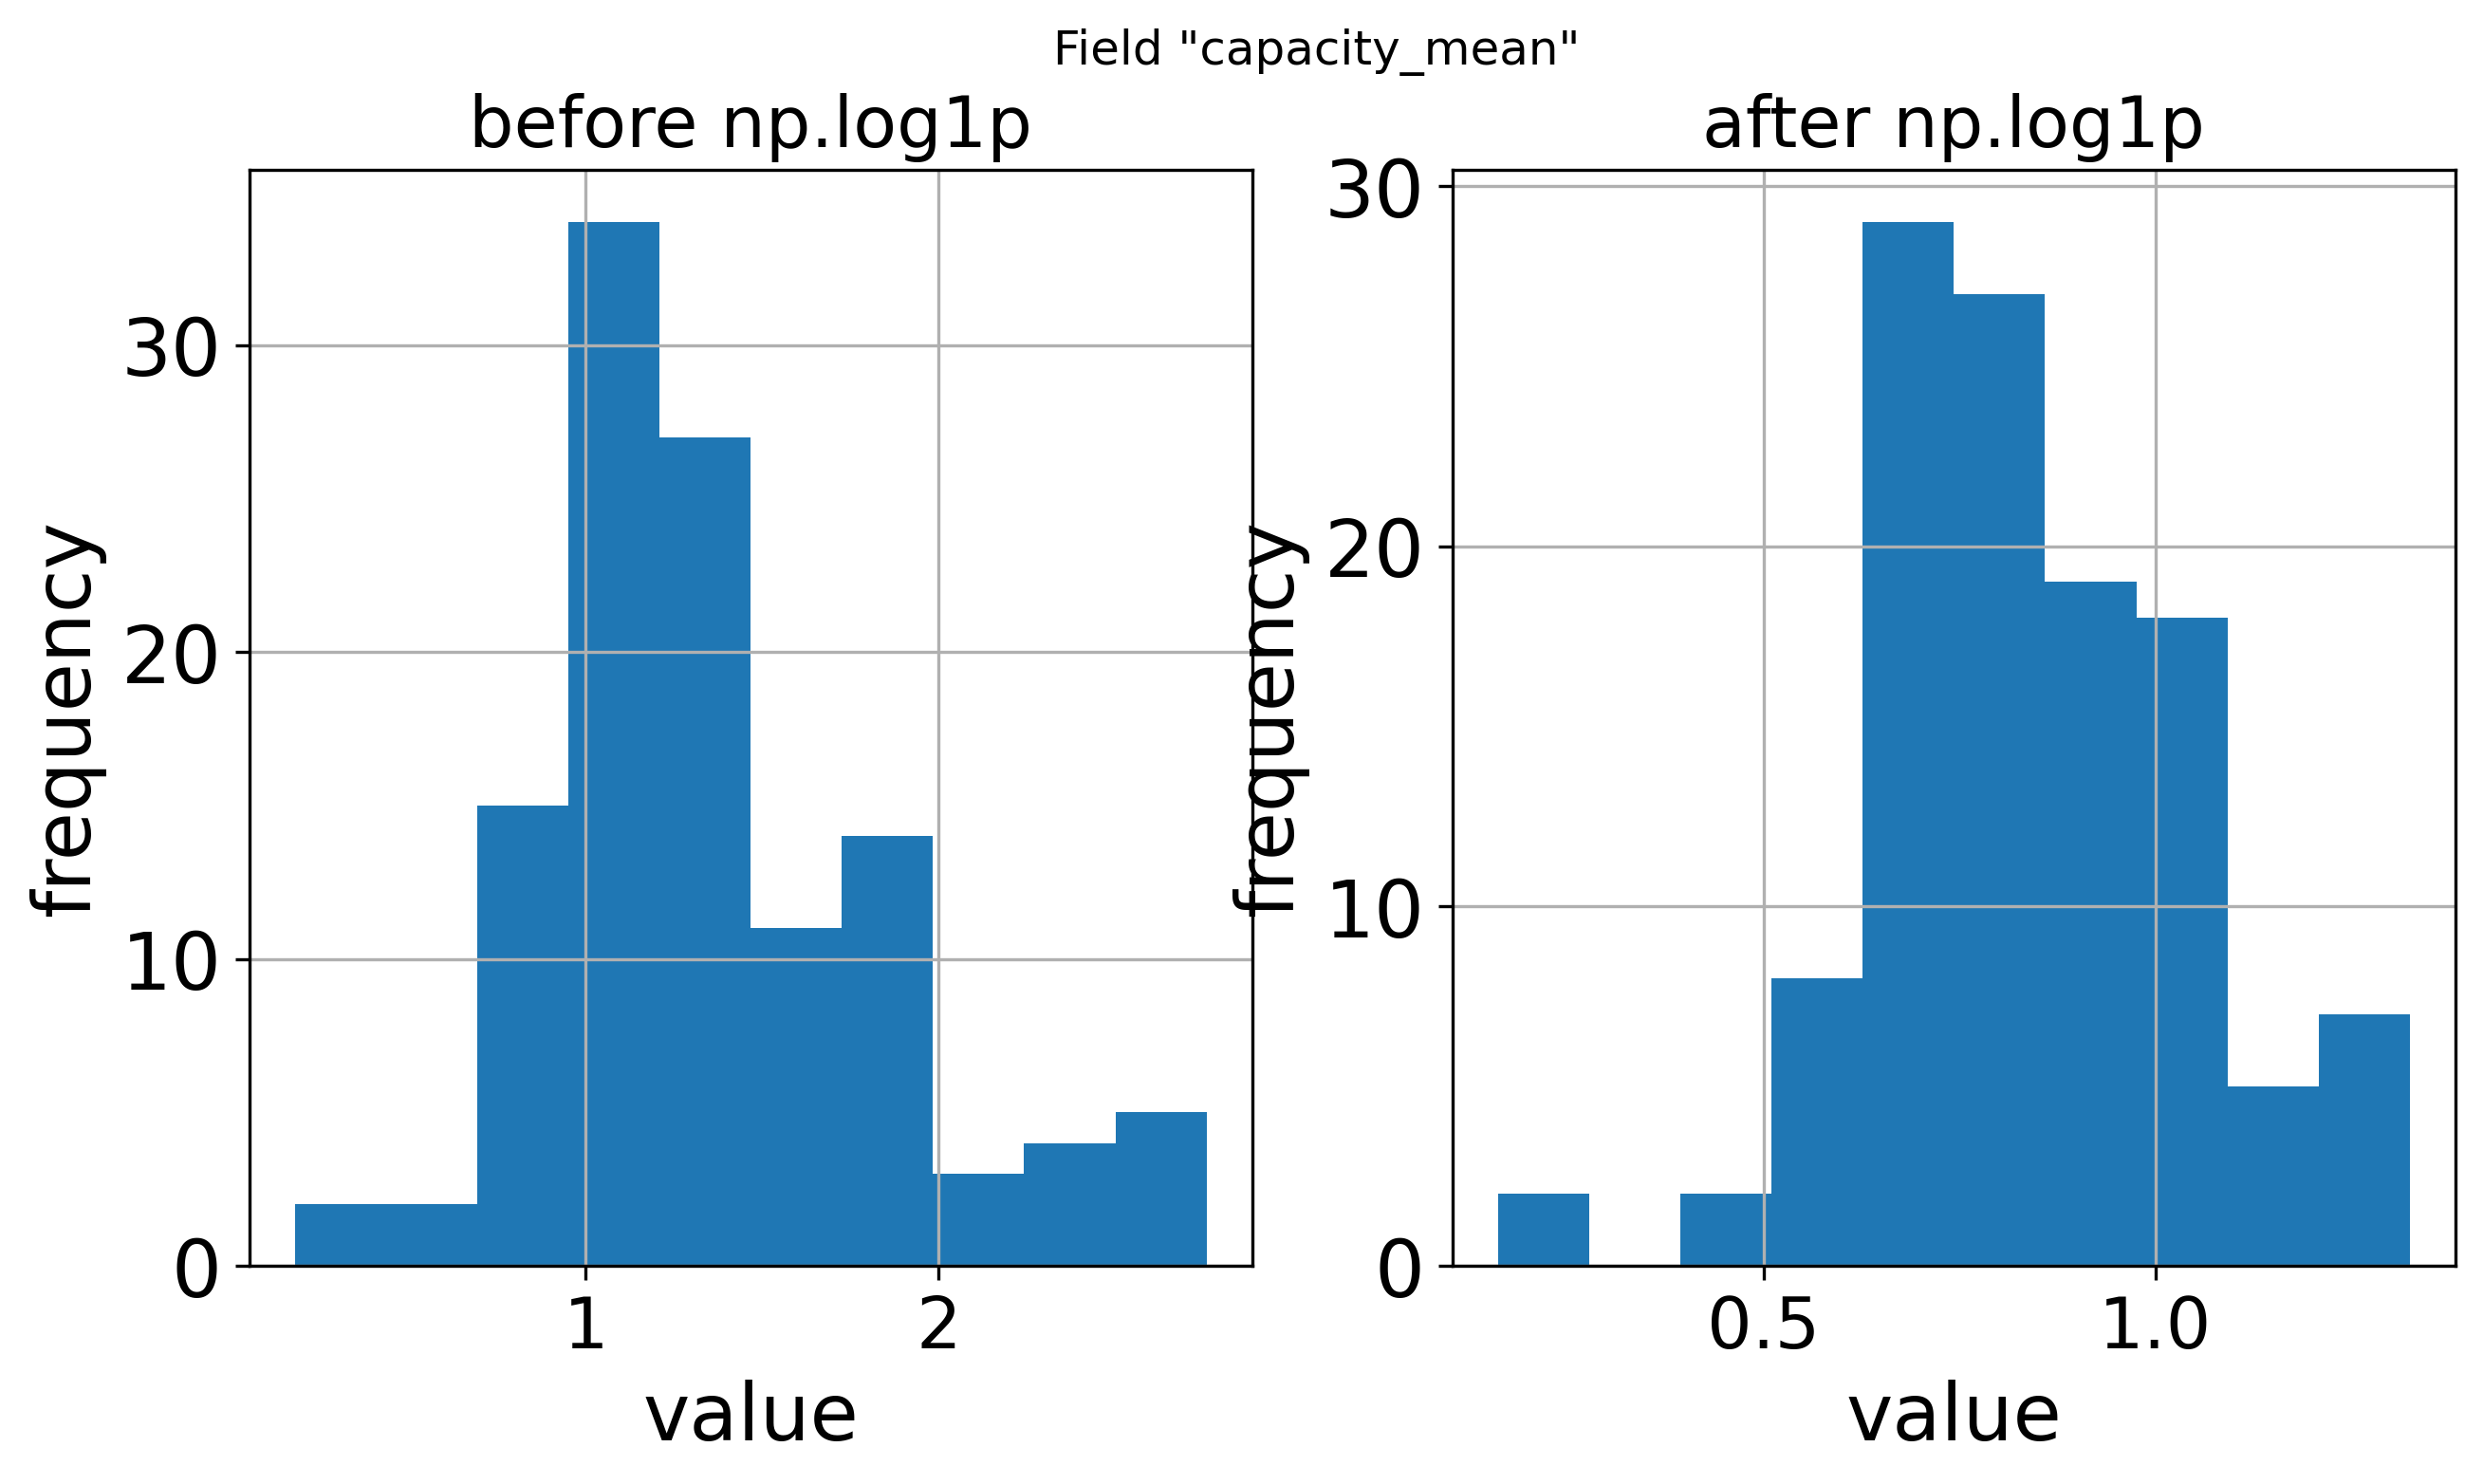

In [14]:
# Let's look at what happens to one of these features, when we apply np.log visually.

# Choose a field
field = "capacity_mean"
# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Create a histogram on the "ax_before" subplot
all_data[field].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
all_data[field].apply(np.log1p).hist(ax=ax_after)

# Formatting of titles etc. for each subplot
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));


In [15]:
skew_vals=np.log1p(all_data['capacity_mean']).skew()
skew_vals

-0.12851866784147378

In [16]:
max_y=np.max(np.log1p(all_data.iloc[:,-1]),axis=0)
min_y=np.min(np.log1p(all_data.iloc[:,-1]),axis=0)
lims = [np.expm1(min_y), np.expm1(max_y)]

In [17]:
## train test split
num_overexpress=25
num_knockout=6
num_class=num_overexpress+num_knockout
total_genes=num_class
X, Y = all_data.iloc[:, 0:num_class], np.log1p(all_data.iloc[:, -1])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [18]:
test_results = {}

## Gradient Boosting Regression

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt_model=GradientBoostingRegressor(random_state=42)
gbrt_model.fit(X_train, Y_train)

GradientBoostingRegressor(random_state=42)

In [20]:
y_pred_train = gbrt_model.predict(X_train)
y_pred_test = gbrt_model.predict(X_test)
test_results['GBRT'] = metrics.mean_squared_error(Y_test, y_pred_test)

In [21]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_test)))

Mean Absolute Error: 0.0816877365365923
Mean Squared Error: 0.013768602334369313
Root Mean Squared Error: 0.11733968780582857


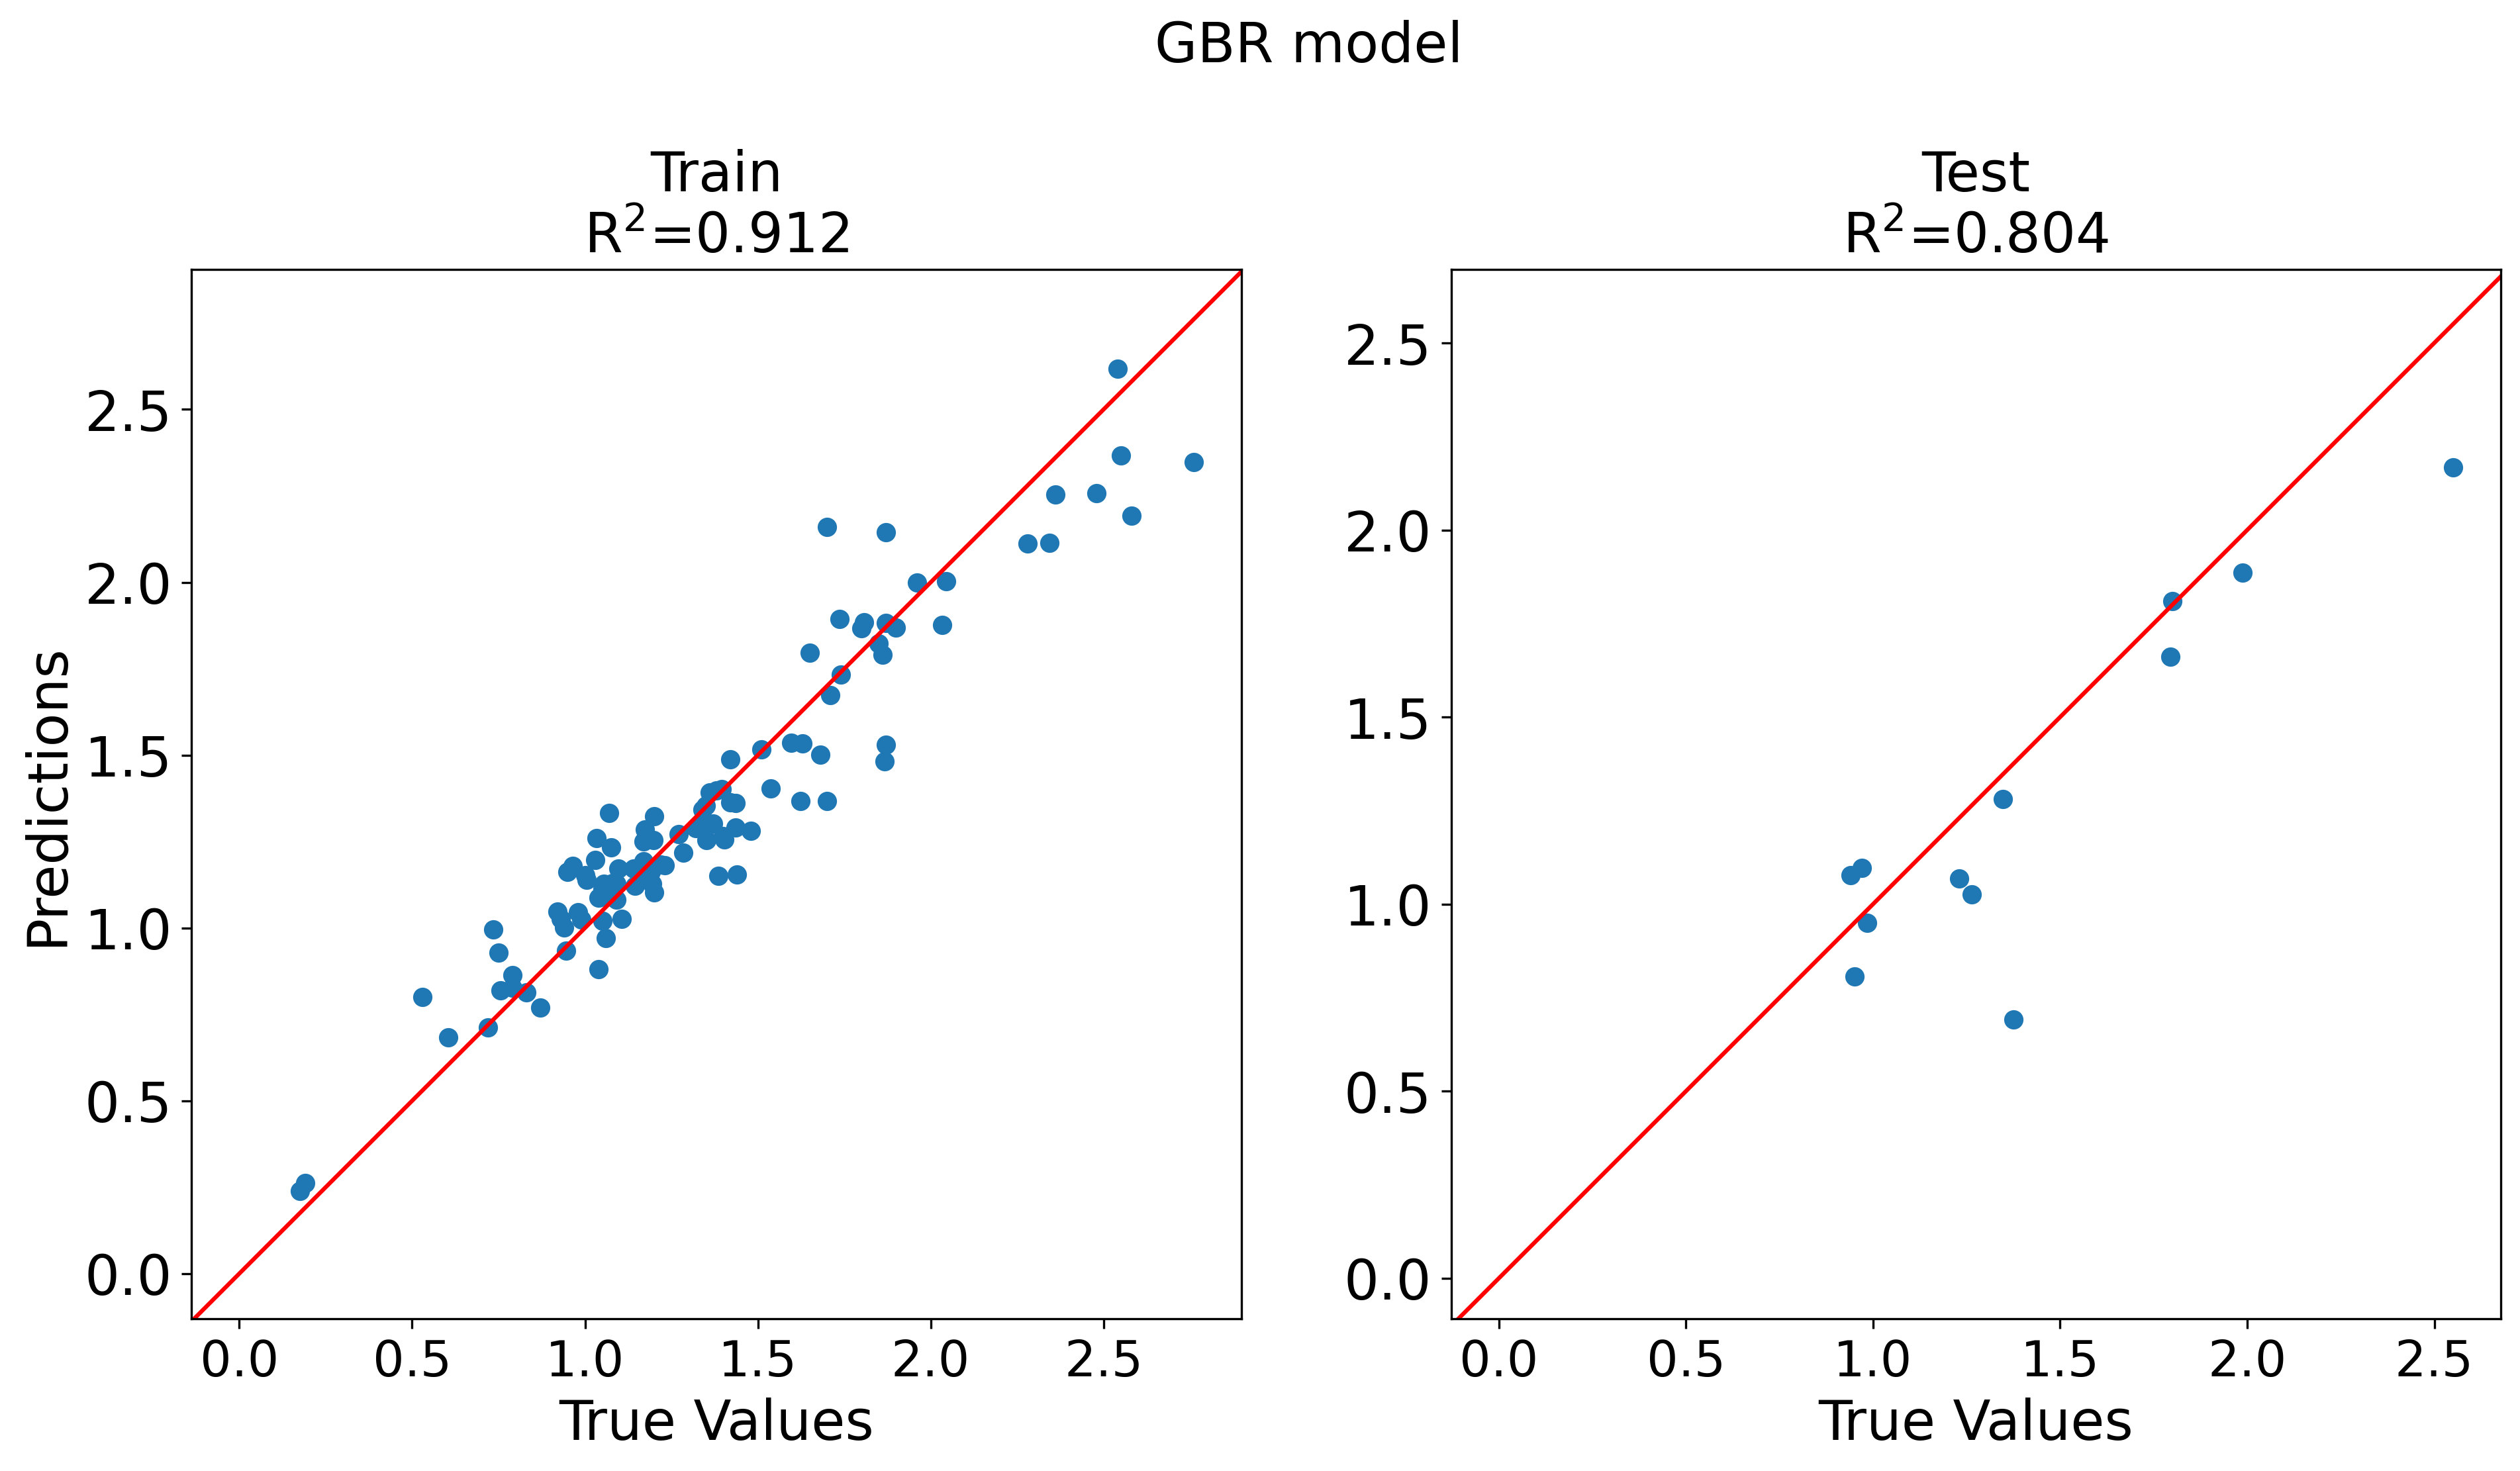

In [22]:
model_name = "GBR model"

plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

In [22]:
gbrt_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

### GridSearchCV--search for the optimal hyperparameters 

In [25]:
param_grid = [{'max_depth': [2, 3, 4], 'learning_rate':[0.1, 0.15, 0.2], 'n_estimators': [100, 150, 200] }]
gbrt=GradientBoostingRegressor(random_state=42)
gbrt_grid = GridSearchCV(gbrt, param_grid, cv=3, verbose=1)
best_model=gbrt_grid.fit(X_train, Y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [26]:
print(best_model.best_params_)

{'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 100}


In [27]:
# Rerun the gbrt with the best combination of hyperparameters
#large max_depth to prevent overfitting
gbrt_model2 = GradientBoostingRegressor(random_state=42, max_depth=4, learning_rate=0.15, n_estimators=100)
gbrt_model2.fit(X_train, Y_train)
y_pred_train = gbrt_model2.predict(X_train)
y_pred_test = gbrt_model2.predict(X_test)
test_results['gbrt_model_search'] = metrics.mean_squared_error(Y_test, y_pred_test)

In [28]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_test)))

Mean Absolute Error: 0.06325844132134918
Mean Squared Error: 0.01390041371168386
Root Mean Squared Error: 0.1179000157408126


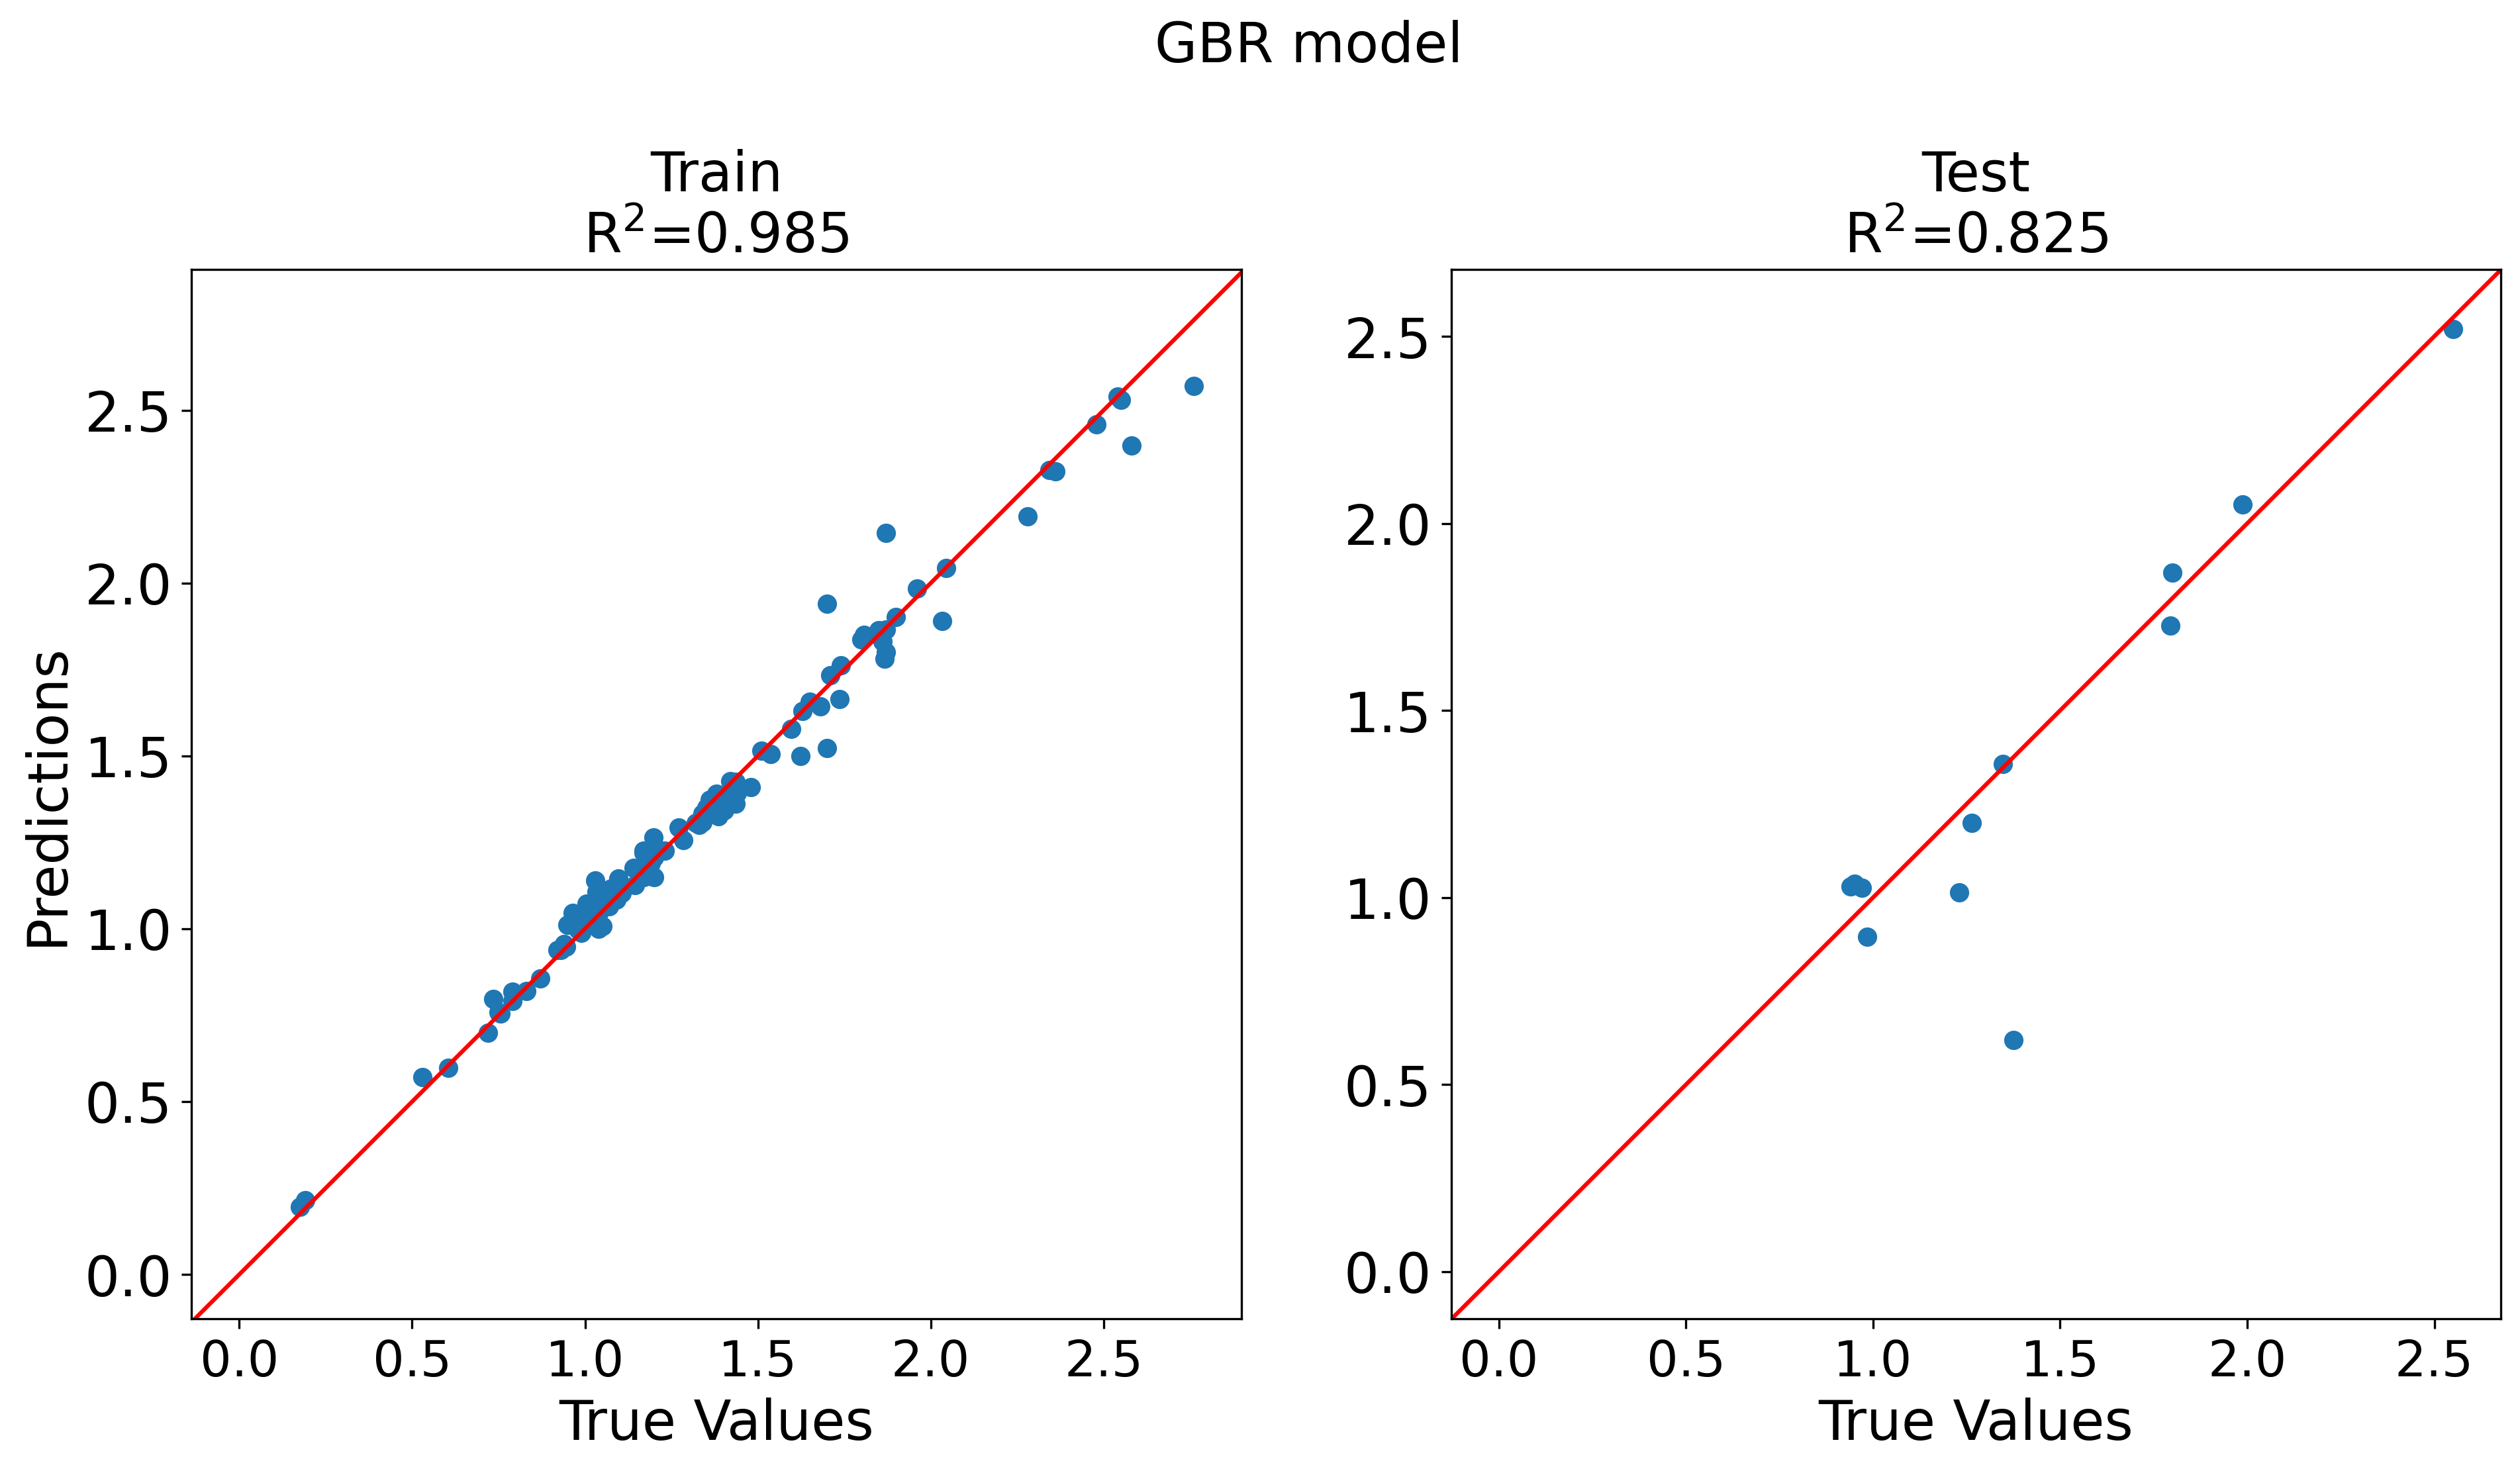

In [29]:
model_name = "GBR model"

plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

In [ ]:
# save the model
with open('save_ML/gbrt_model_117samples_first_round.pkl','wb') as f:
    pickle.dump(gbrt_model2,f)

### screen for combinatorial overexpressed genes

In [40]:
total_genes_vary=25 #only vary the overexpressed genes
screen_data=pd.DataFrame(np.zeros((33554432,gene_num)), columns=data_head[:-1])  #2^25=33554432
lst = list(product([0, 1], repeat=total_genes_vary))
df = pd.DataFrame(lst, columns = data_head[:total_genes_vary])
screen_data[data_head[:total_genes_vary]] = df[data_head[:total_genes_vary]].values

In [29]:
#GBR prediction
y_pred_screen = np.expm1(gbrt_model2.predict(screen_data))

In [43]:
#sort data based on its performance
final_screen = screen_data.copy()
final_screen[data_head[-1]]=y_pred_screen
final_screen_sorted = final_screen.sort_values(data_head[-1], ascending=False)
final_screen_sorted.head(1000).to_csv("data_screen/screen_prediction_first_round_nodup_gbr.csv")